In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
train_on_gpu = torch.cuda.is_available()

In [2]:
def TrainConstructor(path_to_train, path_to_valid, num_workers=4):

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([32,32]),
        transforms.ToTensor()])

    train_dataset = datasets.ImageFolder(path_to_train, transform=train_transform)
    print("Successfully Loaded Training Set.")
    valid_dataset = datasets.ImageFolder(path_to_valid, transform=train_transform)
    print("Successfully Loaded Validation Set.")

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=num_workers, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, num_workers=num_workers, shuffle=True)

    train_category = path_to_train.split('/')[-1]

    return train_loader, valid_loader, train_category

In [3]:
train_loader, valid_loader, train_category = TrainConstructor(
path_to_train='C:/Users/fuzha/Downloads/progan_train/car',
path_to_valid='C:/Users/fuzha/Downloads/progan_val/car', num_workers=1)

Successfully Loaded Training Set.
Successfully Loaded Validation Set.


## Model


In [2]:
class Bottleneck(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(Bottleneck, self).__init__()
        interChannels = 4*growthRate
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, interChannels, kernel_size=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(interChannels)
        self.conv2 = nn.Conv2d(interChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat((x, out), 1)
        return out

class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, growthRate, kernel_size=3,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = torch.cat((x, out), 1)
        return out

class Transition(nn.Module):
    def __init__(self, nChannels, nOutChannels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(nChannels)
        self.conv1 = nn.Conv2d(nChannels, nOutChannels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growthRate, depth, reduction, nClasses, bottleneck):
        super(DenseNet, self).__init__()

        nDenseBlocks = (depth-4) // 3
        if bottleneck:
            nDenseBlocks //= 2

        nChannels = 2*growthRate
        self.conv1 = nn.Conv2d(3, nChannels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans1 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense2 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate
        nOutChannels = int(math.floor(nChannels*reduction))
        self.trans2 = Transition(nChannels, nOutChannels)

        nChannels = nOutChannels
        self.dense3 = self._make_dense(nChannels, growthRate, nDenseBlocks, bottleneck)
        nChannels += nDenseBlocks*growthRate

        self.bn1 = nn.BatchNorm2d(nChannels)
        self.fc = nn.Linear(nChannels, nClasses)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def _make_dense(self, nChannels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(Bottleneck(nChannels, growthRate))
            else:
                layers.append(SingleLayer(nChannels, growthRate))
            nChannels += growthRate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = torch.squeeze(F.avg_pool2d(F.relu(self.bn1(out)), 8))
        out = F.log_softmax(self.fc(out))
        return out



In [5]:
model = DenseNet(growthRate=24, depth=100, reduction=0.5,bottleneck=True, nClasses=2).cuda()
# model = models.densenet161(pretrained=True).cuda()
model = nn.DataParallel(model)

## Loss Function and Optimizer

In [6]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

## Train

In [ ]:
# train_categories = ['cat', 'horse', 'person', 'sofa']

# for j in range(4):
    # print('For training category ' + train_categories[j] + ':')
    # train_loader, valid_loader, train_category = TrainConstructor(
    # path_to_train='C:/Users/fuzha/Downloads/progan_train/' +  train_categories[j],
    # path_to_valid='C:/Users/fuzha/Downloads/progan_val/' +  train_categories[j], num_workers=1)
    
    # model = DenseNet(growthRate=24, depth=100, reduction=0.5,bottleneck=True, nClasses=2).cuda()
    # model = nn.DataParallel(model)
    # criterion = nn.CrossEntropyLoss()

    # optimizer = torch.optim.SGD([
    #     {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    #     {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
    # ])

# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    torch.cuda.empty_cache()    
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    training_vis.append(train_loss)
    valid_vis.append(valid_loss)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
#         torch.save(model.state_dict(), 'DenseNet_' + train_categories[j] + '_' + str(epoch) + '.pt')

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'DenseNet_car_best.pt')
        valid_loss_min = valid_loss

np.savetxt('DenseNet_car_best.txt', np.array([training_vis, valid_vis]))
plt.plot(range(epoch), training_vis)
plt.scatter(range(epoch), training_vis)
plt.scatter(range(epoch), valid_vis)
plt.plot(range(epoch), valid_vis)
plt.savefig('DenseNet_car_best.svg')
plt.clf()

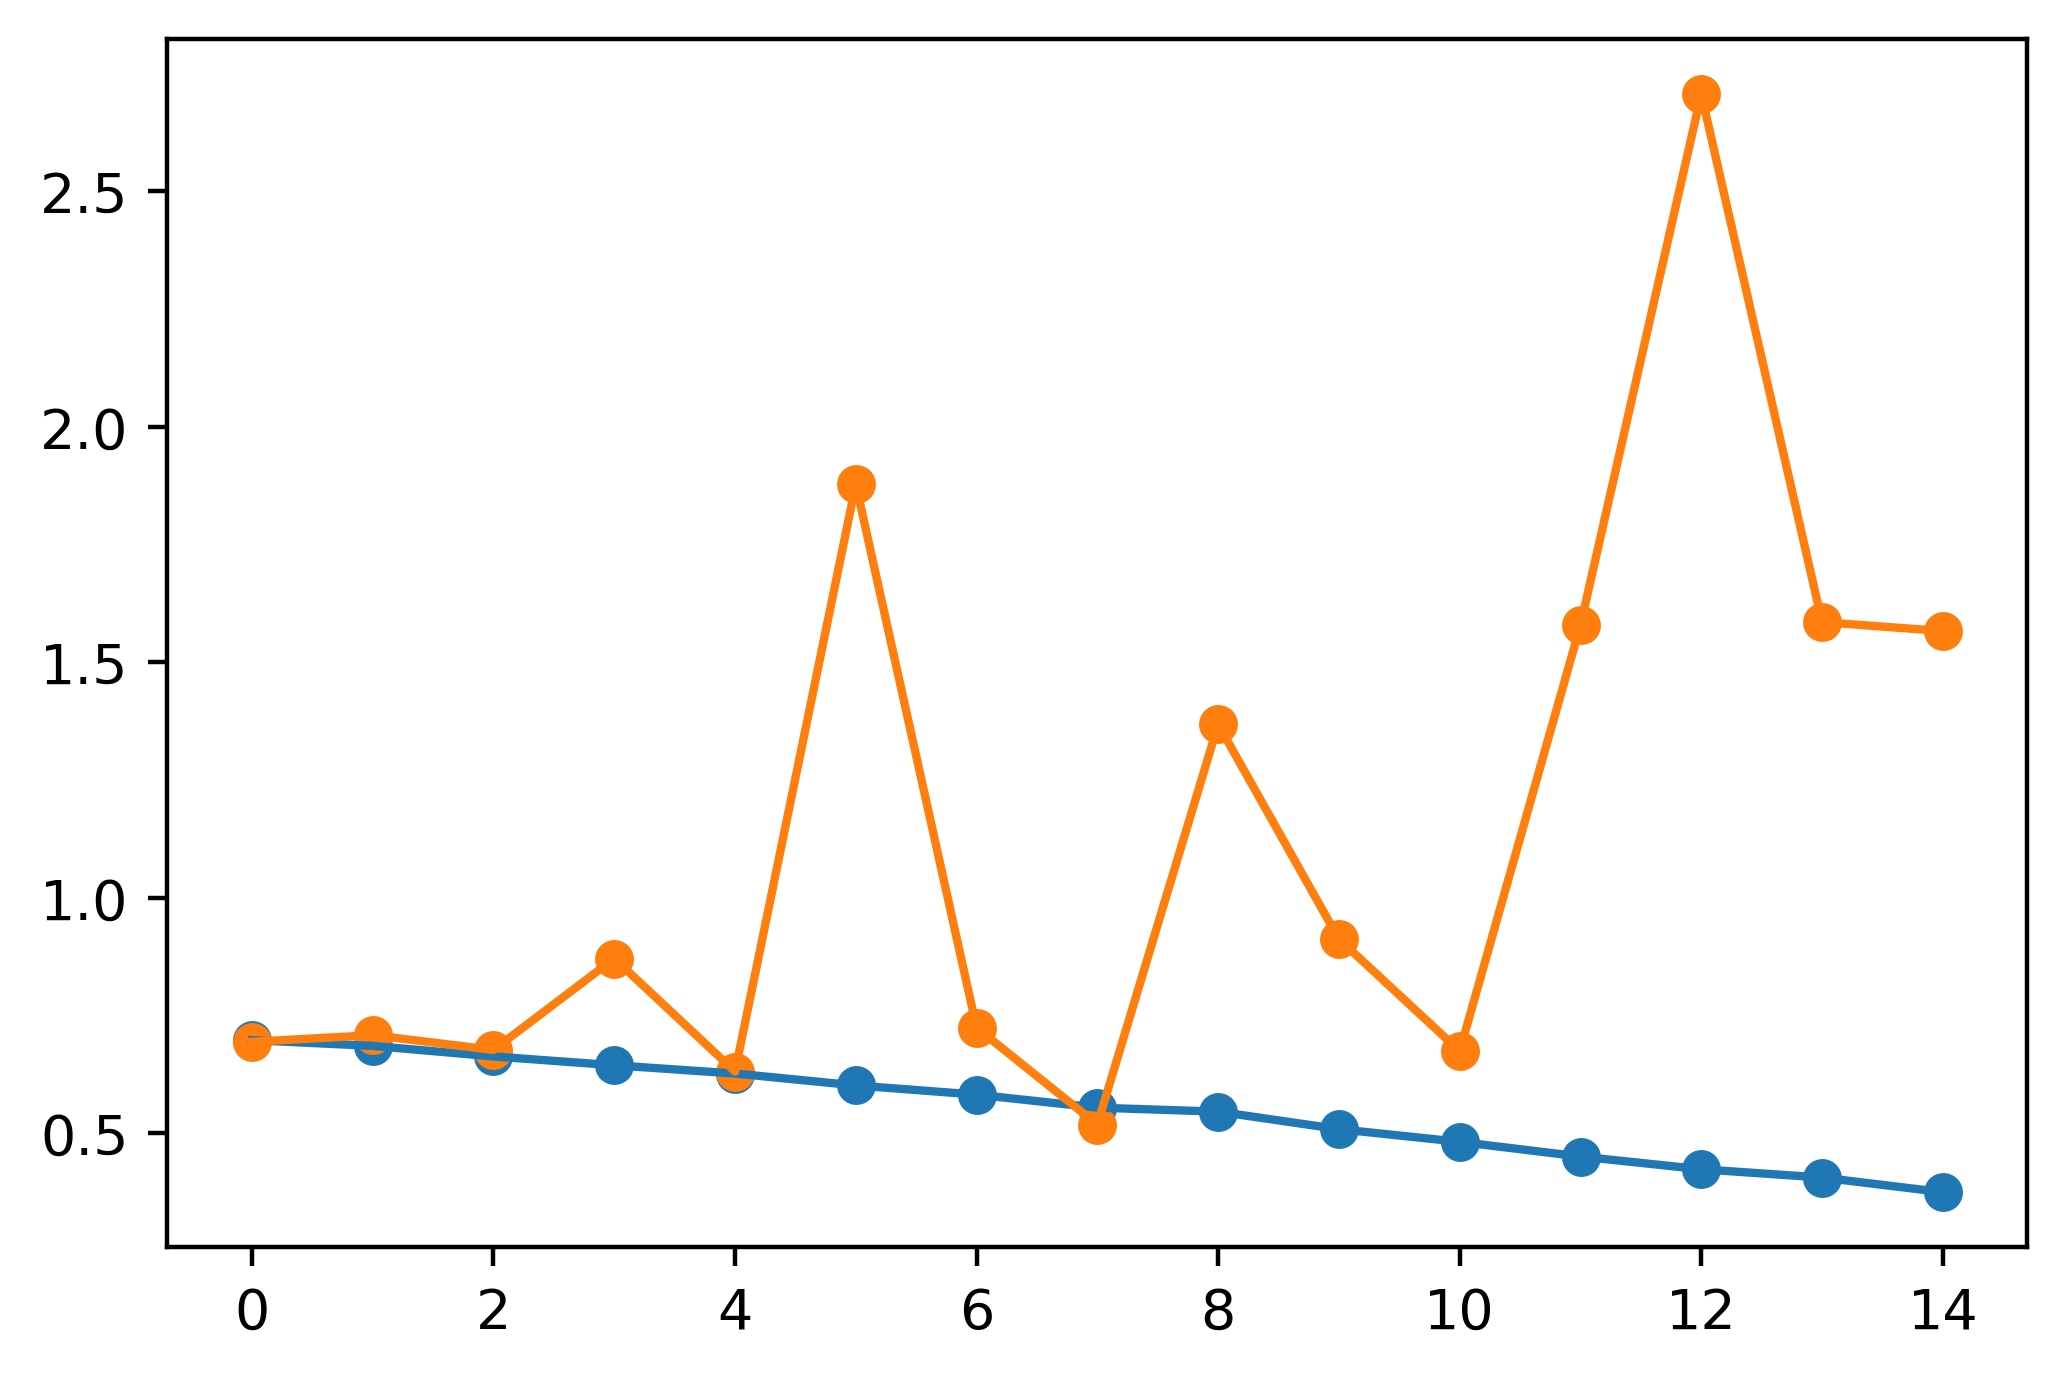

In [ ]:
[training_vis, valid_vis] = np.loadtxt('DenseNet_sofa.txt')
plt.plot(range(15), training_vis)
plt.scatter(range(15), training_vis)
plt.scatter(range(15), valid_vis)
plt.plot(range(15), valid_vis)
plt.savefig('DenseNet_sofa.svg')

## Load Model

In [13]:
model = DenseNet(growthRate=24, depth=100, reduction=0.5,bottleneck=True, nClasses=2).cuda()
model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('DenseNet_sofa_best.pt'))

<All keys matched successfully>

## Test

In [3]:
def TestConstructor(path_to_test, classes=None, num_workers=4):

    test_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([32,32]),
        transforms.ToTensor()])

    test_dataset = datasets.ImageFolder(path_to_test, transform=test_transform)
    print("Successfully Loaded Test Set.")

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, num_workers=num_workers)

    if classes != None:
        print("Number of Classes:", len(classes))

    return test_loader, classes

In [14]:
test_categories = ['airplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

for j in range(20):
    print('For test category ' + test_categories[j] + ':')
    test_loader, classes = TestConstructor(path_to_test='C:/Users/fuzha/Downloads/CNN_synth_testset/progan/' + test_categories[j], classes=['Real','Fake'],num_workers=1)

# test_loader, classes = TestConstructor(path_to_test='C:/Users/fuzha/Downloads/CNN_synth_testset/progan/car', classes=['Real','Fake'], num_workers=1)

# track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    model.eval()
    # iterate over test data
    for data, target in test_loader:
    #     print(target)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
    #     print(output)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
    #     print(pred)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(2):
    #         print(i)
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}'.format(test_loss))

    for i in range(2):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('Test Accuracy (Overall): %2d%% (%2d/%2d)\n' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

For test category airplane:
Successfully Loaded Test Set.
Number of Classes: 2


C:\Users\fuzha\AppData\Local\Temp/ipykernel_69104/416932984.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))


Test Loss: 0.829621
Test Accuracy of  Real: 68% (136/200)
Test Accuracy of  Fake: 47% (95/200)
Test Accuracy (Overall): 57% (231/400)

For test category bicycle:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.663330
Test Accuracy of  Real: 77% (154/200)
Test Accuracy of  Fake: 51% (102/200)
Test Accuracy (Overall): 64% (256/400)

For test category bird:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.881173
Test Accuracy of  Real: 75% (151/200)
Test Accuracy of  Fake: 32% (65/200)
Test Accuracy (Overall): 54% (216/400)

For test category boat:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.662421
Test Accuracy of  Real: 74% (148/200)
Test Accuracy of  Fake: 52% (105/200)
Test Accuracy (Overall): 63% (253/400)

For test category bottle:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.772058
Test Accuracy of  Real: 85% (171/200)
Test Accuracy of  Fake: 32% (65/200)
Test Accuracy (Overall): 59% (236/400)

For test category 

In [4]:
train_categories = ['car', 'cat', 'horse', 'person', 'sofa']
test_gans = ['biggan','cyclegan','deepfake','san','stargan','stylegan','stylegan2','whichfaceisreal']
cyclegan_categories = ['apple','horse','orange','summer','winter','zebra']
stylegan_categories = ['bedroom','car','cat']
stylegan2_categories = ['car','cat','church','horse']

for train_category in train_categories:
    print('For train category ' + train_category + ':')
    model = DenseNet(growthRate=24, depth=100, reduction=0.5,bottleneck=True, nClasses=2).cuda()
    model = nn.DataParallel(model)
    criterion = nn.CrossEntropyLoss()
    model.load_state_dict(torch.load('DenseNet_' + train_category + '_best.pt'))

    for test_gan in test_gans:
        print('For test gan ' + test_gan + ':')
        test_categories = []
        if test_gan == 'cyclegan':
            test_categories = cyclegan_categories
        elif test_gan == 'stylegan':
            test_categories = stylegan_categories
        elif test_gan == 'stylegan2':
            test_categories = stylegan2_categories

        if len(test_categories) == 0:
            test_loader, classes = TestConstructor(path_to_test='C:/Users/fuzha/Downloads/CNN_synth_testset/' + test_gan, classes=['Real','Fake'], num_workers=1)

            # track test loss
            test_loss = 0.0
            class_correct = list(0. for i in range(2))
            class_total = list(0. for i in range(2))

            model.eval()
            # iterate over test data
            for data, target in test_loader:
            #     print(target)
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
            #     print(output)
                # calculate the batch loss
                loss = criterion(output, target)
                # update test loss 
                test_loss += loss.item()*data.size(0)
                # convert output probabilities to predicted class
                _, pred = torch.max(output, 1)
            #     print(pred)
                # compare predictions to true label
                correct_tensor = pred.eq(target.data.view_as(pred))
                correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
                # calculate test accuracy for each object class
                for i in range(2):
            #         print(i)
                    label = target.data[i]
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

            # average test loss
            test_loss = test_loss/len(test_loader.dataset)
            print('Test Loss: {:.6f}'.format(test_loss))

            for i in range(2):
                if class_total[i] > 0:
                    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                        classes[i], 100 * class_correct[i] / class_total[i],
                        np.sum(class_correct[i]), np.sum(class_total[i])))
                else:
                    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

            print('Test Accuracy (Overall): %2d%% (%2d/%2d)\n' % (
                100. * np.sum(class_correct) / np.sum(class_total),
                np.sum(class_correct), np.sum(class_total)))

        else:
            for test_category in test_categories:
                print('For test category ' + test_category + ':')
                test_loader, classes = TestConstructor(path_to_test='C:/Users/fuzha/Downloads/CNN_synth_testset/' + test_gan + '/' + test_category, classes=['Real','Fake'], num_workers=1)

                # track test loss
                test_loss = 0.0
                class_correct = list(0. for i in range(2))
                class_total = list(0. for i in range(2))

                model.eval()
                # iterate over test data
                for data, target in test_loader:
                #     print(target)
                    # move tensors to GPU if CUDA is available
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()
                    # forward pass: compute predicted outputs by passing inputs to the model
                    output = model(data)
                #     print(output)
                    # calculate the batch loss
                    loss = criterion(output, target)
                    # update test loss 
                    test_loss += loss.item()*data.size(0)
                    # convert output probabilities to predicted class
                    _, pred = torch.max(output, 1)
                #     print(pred)
                    # compare predictions to true label
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
                    # calculate test accuracy for each object class
                    for i in range(2):
                #         print(i)
                        label = target.data[i]
                        class_correct[label] += correct[i].item()
                        class_total[label] += 1

                # average test loss
                test_loss = test_loss/len(test_loader.dataset)
                print('Test Loss: {:.6f}'.format(test_loss))

                for i in range(2):
                    if class_total[i] > 0:
                        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                            classes[i], 100 * class_correct[i] / class_total[i],
                            np.sum(class_correct[i]), np.sum(class_total[i])))
                    else:
                        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

                print('Test Accuracy (Overall): %2d%% (%2d/%2d)\n' % (
                    100. * np.sum(class_correct) / np.sum(class_total),
                    np.sum(class_correct), np.sum(class_total)))

For train category car:
For test gan biggan:
Successfully Loaded Test Set.
Number of Classes: 2


C:\Users\fuzha\AppData\Local\Temp/ipykernel_75944/416932984.py:98: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))


Test Loss: 1.015704
Test Accuracy of  Real: 68% (1373/2000)
Test Accuracy of  Fake: 42% (856/2000)
Test Accuracy (Overall): 55% (2229/4000)

For test gan cyclegan:
For test category apple:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.920259
Test Accuracy of  Real: 68% (181/266)
Test Accuracy of  Fake: 31% (77/248)
Test Accuracy (Overall): 50% (258/514)

For test category horse:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.883903
Test Accuracy of  Real: 69% (83/120)
Test Accuracy of  Fake: 48% (68/140)
Test Accuracy (Overall): 58% (151/260)

For test category orange:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 0.783837
Test Accuracy of  Real: 58% (144/248)
Test Accuracy of  Fake: 50% (135/266)
Test Accuracy (Overall): 54% (279/514)

For test category summer:
Successfully Loaded Test Set.
Number of Classes: 2
Test Loss: 1.032935
Test Accuracy of  Real: 66% (205/308)
Test Accuracy of  Fake: 39% (95/238)
Test Accuracy (Overall): 54% (